# Two Stage Floating Catchment Area DEMO

Authors: [Irene Farah](https://www.linkedin.com/in/imfarah/),  [Julia Koschinsky](https://www.linkedin.com/in/julia-koschinsky-657599b1/), [Logan Noel](https://www.linkedin.com/in/lmnoel/).   
Contact: [Julia Koschinsky](mailto:jkoschinsky@uchicago.edu)  

Research assistance of [Shiv Agrawal](http://simonlab.uchicago.edu/people/ShivAgrawal.html), [Caitlyn Tien](https://www.linkedin.com/in/caitlyn-tien-0b784b161/) and [Richard Lu](https://www.linkedin.com/in/richard-lu-576874155/) is gratefully acknowledged.

Center for Spatial Data Science  
University of Chicago  

July 30, 2019

---

This notebook calculates the Two Stage Floating Catchment Area (TSFCA) model, using the travel time matrix as an input -- in this case, access to per capita spending for different types of health services. 

TSFCA Models are a type of gravity model popularized by Luo and Wang in 2003 to estimate spatial access gaps to primary care. They are calculated in two stages (using the primary care example): In a first stage, the ratio of doctors to the nearby population is calculated for every provider. In the 2nd stage, these ratios are summed for every point of origin (such as a tract centroid) within a travel threshold. In other words, the ratio of doctors to people is first calculated for the catchment areas of doctors (1st stage) and then summed for the catchment areas around people's point of origins, like their home (2nd stage). 

Each model follows the same procedure as the one presented in access models:

1. Define the model by providing the appropriate arguments 
2. Calculate the model  
3. Subset, aggregate, plot the results (optional)
4. Save the result as a csv or tmx file 

Each of these steps are demonstrated below.

---

**_Standard Data Requirements_**  
Each model uses inputs from both the sources and destination csv files. Destinations need to be constrained to the spatial extent of the origins.

* Source File
    * Unique index identifier (**ID**) (integer or real)  
    * **Latitude** and **longitude** coordinates (real)
    * To aggregate: **larger areal ID**  
    * **Population** within the areal unit  
    
* Destination File
    * Unique index identifier (**ID**) (integer or real)
    * **Latitude** and **longitude** coordinates (real)
    * **Category** for each type of facility
    * **Capacity** for each facility
    * To aggregate: **larger areal ID**

In [ ]:
cd ../..

In [ ]:
# Import modules
from spatial_access.p2p import *
from spatial_access.Models import *

In [3]:
# View sources and destinations for Chicago health facilities
import pandas as pd
sources_df = pd.read_csv('./data/input_data/sources/tracts2010.csv')
dests_df = pd.read_csv('./data/input_data/destinations/health_chicago.csv')

**Read in travel time matrix generated in [1_matrix.ipynb](./1_matrix.ipynb)**:

In [4]:
matrix_df = pd.read_csv('./data/output_data/matrices/walk_asym_health_tracts.csv')

In [5]:
sources_df.head()

,geoid10,lon,lat,Pop2014,Pov14,community
0,17031842400,-87.630040,41.742475,5157,769,44
1,17031840300,-87.681882,41.832094,5881,1021,59
2,17031841100,-87.635098,41.851006,3363,2742,34
3,17031841200,-87.683342,41.855562,3710,1819,31
4,17031838200,-87.675079,41.870416,3296,361,28


In [6]:
#Note that the capacity field is not real but only for demo purposes
dests_df.head()

,ID,Facility,lat,lon,Type,capacity,category,community
0,1,"American Indian Health Service of Chicago, Inc.",41.956676,-87.651879,5,127000,Other Health Providers,3
1,2,Hamdard Center for Health and Human Services,41.997852,-87.669535,5,190000,Other Health Providers,77
2,3,Infant Welfare Society of Chicago,41.924904,-87.717270,5,137000,Other Health Providers,22
3,4,Mercy Family - Henry Booth House Family Health...,41.841694,-87.624790,5,159000,Other Health Providers,35
4,6,Cook County - Dr. Jorge Prieto Health Center,41.847143,-87.724975,5,166000,Other Health Providers,30


In [7]:
matrix_df.head()

,Unnamed: 0,1,2,3,4,6,8,9,10,11,...,198,199,200,201,202,203,204,205,206,Unnamed: 200
0,17031842400,17870,21397,17892,8483,13529,12425,5704,16935,7565,...,13236,16767,11419,14396,10325,12874,9266,8919,1718,NaN
1,17031840300,11391,13937,8845,4120,3713,3939,6358,8448,3721,...,4671,7050,3438,22725,1777,4898,3682,4482,8430,NaN
2,17031841100,9050,12577,9155,1374,5748,4035,5015,8198,2295,...,4799,8430,3042,21403,4769,4410,525,1494,9341,NaN
3,17031841200,9649,12195,7306,4588,3049,2017,8015,6846,5313,...,2958,5512,1672,24415,3590,3156,3484,4701,10378,NaN
4,17031838200,8222,10768,6219,5068,3794,590,8589,5440,5887,...,1552,4789,853,24887,5067,1729,3964,5181,10959,NaN


### Specifications: Coverage Model:

**name = tsfca( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (sources file)
* **destinations_filename** (destinations file)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.


**name.calculate():**
- **upper_threshold** (the time (in seconds) in which the origin and destinations are considered to be out of range of each other)

Functions within the TSFCA Model class (use as name.function()):  
- calculate () 
- model_results (results of the TSFCA calculations)
- write_csv () 
- set.focus.categories()
- aggregate ()
- write_aggregated_results()
- plot_cdf()
- plot_choropleth()

Each function is demonstrated below

When defining the TSFCA Model, use the previously generated shortest-path matrix. Also specify the desired distance decay function. Here, source_column_names and dest_column_names are not specified so the model will ask the user to map column names to expected values. 

When defining the TSFCA Model, use the previously generated travel time matrix. Also specify the desired distance decay function. Here, source_column_names and dest_column_names are not specified so the model will ask you to map column names to expected values.


In [ ]:
#Specify the network type here
tsfca = TSFCA(network_type='walk',
              sources_filename='./data/input_data/tracts2010.csv',
              destinations_filename='./data/input_data/health_chicago.csv')

In [ ]:
tsfca.calculate(upper_threshold=1800)

In [17]:
#Output
#Note that the capacity field is not real but only for demo purposes
tsfca.model_results.head()

,percap_spend_Other Health Providers,percap_spend_Hospitals,percap_spend_All Free Health Clinics,percap_spend_School-Based Health Centers,percap_spend_Federally Qualified Health Centers,percap_spend_all_categories
1,0.000000,0.000000,0.000000,2.200301,0.000000,2.200301
2,0.000000,0.000000,0.000000,3.192260,5.272095,8.464355
3,5.050584,1.728574,3.377900,3.496114,2.546678,16.199851
4,0.000000,5.871718,0.000000,8.771760,12.809737,27.453215
5,2.542609,11.854331,2.499107,10.075997,7.323656,34.295700


**Scores**
Note that "per capita spending" values are demo values, not real values.

- tsfca_Federally Qualified Health Centers is the access to per capita spending by Federally Qualified Health Centers
- tsfca_School-Based Health Centers is the access to per capita spending by School-based Health Centers
- tsfca_All Free Health Clinics is the access to per capita spending by free health clinics
- tsfca_Hospitals is the access to per capita spending by hospitals
- tsfca_Other Health Providers is the access to per capita spending by all other healthcare providers
- tsfca_all_categories is the sum of the above five categories

Merge the per capita spending data to the origin's shapefile and map them out in order to view the distribution of the access to per capita spending by tract:

<img src="./figures/tsfca_results.png" width = 600>

In [18]:
#Writes output to csv
tsfca.model_results.to_csv('./data/tsfca/tsfca_results.csv')

#### **Calculate the TSFCA Score for a Subset of the Data**

In [ ]:
#Set the Subset to Federally Qualified Health Centers
tsfca.set_focus_categories(['Federally Qualified Health Centers'])

In [ ]:
#Set the importance and variety weights:

dict = {
"Federally Qualified Health Centers": [10,10,10,10,10]
}

In [ ]:
#Calculate the score for 30 minutes travel time
tsfca.calculate(upper_threshold=1800)

In [ ]:
#Preview the first 5 rows of the results
tsfca.model_results.head()

In [ ]:
#Save the results to csv
tsfca.model_results.to_csv('FQHC_tsfca.csv')

### Aggregation to larger areas

In [19]:
#Gets the output of the aggregation by access to coverage value by community area
#Note that the capacity field is not real but only for demo purposes

tsfca.aggregate(aggregation_type=None,
                shapefile='./data/chicago_boundaries/chi_comm_boundaries.shp',
                spatial_index='community',
                projection='epsg:4326').head()

,percap_spend_Other Health Providers,percap_spend_Hospitals,percap_spend_All Free Health Clinics,percap_spend_School-Based Health Centers,percap_spend_Federally Qualified Health Centers,percap_spend_all_categories
spatial_index,,,,,,
ALBANY PARK,0.000000,1.284000,0.00000,3.121864,3.193365,7.599230
ARCHER HEIGHTS,0.000000,0.000000,0.00000,0.000000,6.985460,6.985460
ARMOUR SQUARE,6.248138,1.382859,0.67558,4.595124,4.006786,16.908487
ASHBURN,0.000000,1.024378,0.00000,0.000000,0.000000,1.024378
AUBURN GRESHAM,0.000000,0.000000,0.00000,1.906927,2.853610,4.760537


In [10]:
#For community areas write to csv
tsfca.write_aggregated_results(filename = "./data/tsfca/tsfca_aggregated.csv", output_type = 'csv')

## CDF Plot
The following cumulative distribution function shows the number of tracts for a given TSFCA value (e.g. access to per capita spending or physicians per patients).


INFO:spatial_access.BaseModel:Plot was saved to: /Users/whlu/spatial_access/data/tsfca/tsfca_cdf_plot.png


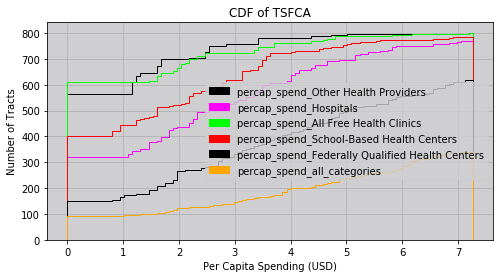

In [11]:
tsfca.plot_cdf(filename = './data/tsfca/tsfca_cdf_plot.png', 
               plot_type = "percap", title = 'CDF of TSFCA',
               xlabel = 'TSFCA',
               ylabel = 'Number of Tracts')

The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_tsfca.png" width="650" title="Optional title"  align="center">

### Choropleth Mapping

INFO:spatial_access.BaseModel:Figure was saved to: /Users/whlu/spatial_access/data/tsfca/tsfca_choropleth.png


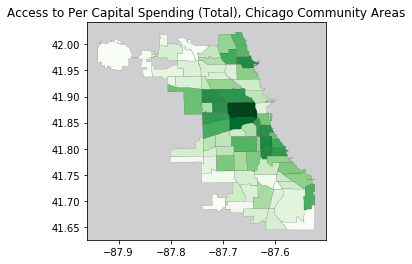

In [12]:
tsfca.plot_choropleth(column = "percap_spend_all_categories", 
                      shapefile='/./data/chicago_boundaries/chi_comm_boundaries.shp',
                      title = 'Access to TSFCA Value, Chicago Community Areas',
                      include_destinations = False,
                      filename = './data/tsfca/tsfca_choropleth.png')